In [16]:
library(tidyverse)
library(tidymodels)
install.packages("kknn")
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# read the data and assign column names
pulsar_data <- read_csv("https://raw.githubusercontent.com/sinamhdv/DSCI-100-project-group-26/main/HTRU_2.csv", col_names = FALSE)
colnames(pulsar_data) <- c("profile_mean", "profile_stdev", "profile_skewness", "profile_kurtosis", "dm_mean", "dm_stdev", "dm_skewness", "dm_kurtosis", "class")
head(pulsar_data, n = 6)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


profile_mean profile_stdev profile_skewness profile_kurtosis dm_mean 
1 140.56250    55.68378      -0.23457141      -0.6996484       3.199833
2 102.50781    58.88243       0.46531815      -0.5150879       1.677258
3 103.01562    39.34165       0.32332837       1.0511644       3.121237
4 136.75000    57.17845      -0.06841464      -0.6362384       3.642977
5  88.72656    40.67223       0.60086608       1.1234917       1.178930
6  93.57031    46.69811       0.53190485       0.4167211       1.636288
  dm_stdev dm_skewness dm_kurtosis class
1 19.11043  7.975532    74.24222   0    
2 14.86015 10.576487   127.39358   0    
3 21.74467  7.735822    63.17191   0    
4 20.95928  6.896499    53.59366   0    
5 11.46872 14.269573   252.56731   0    
6 14.54507 10.621748   131.39400   0

In [3]:
# change class to factor
pulsar_data <- pulsar_data |>
    mutate(class = as.factor(class))

In [4]:
# train-test split
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

In [5]:
# summarize data
pulsar_train |>
    group_by(class) |>
    summarize(class_count = n(), across(profile_mean:dm_kurtosis, mean))

summarize(pulsar_train, across(profile_mean:dm_kurtosis, ~ sum(is.na(.x))))

class class_count profile_mean profile_stdev profile_skewness
1 0     12172       116.63992    47.37484      0.2096715       
2 1      1251        56.89777    38.65445      3.1234064       
  profile_kurtosis dm_mean   dm_stdev dm_skewness dm_kurtosis
1  0.3800586        8.775175 23.18983 8.896843    114.36724  
2 15.5302774       49.477562 56.62902 2.749915     17.39349

profile_mean profile_stdev profile_skewness profile_kurtosis dm_mean dm_stdev
1 0            0             0                0                0       0       
  dm_skewness dm_kurtosis
1 0           0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


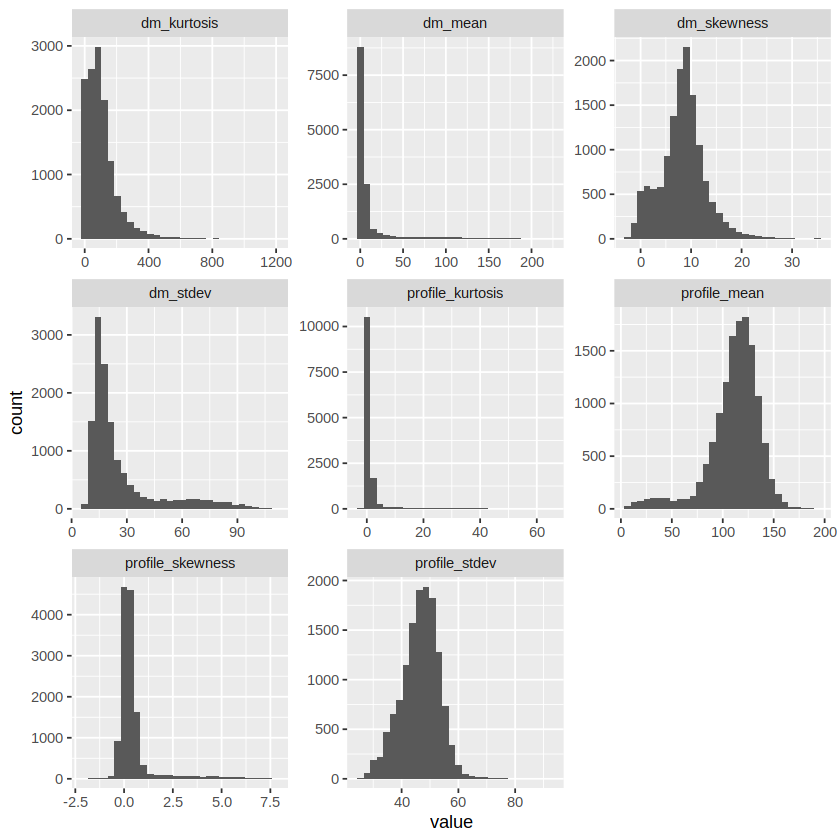

In [6]:
# visualize the data
long_data <- pulsar_train |>
    select(profile_mean:dm_kurtosis) |>
    gather(column_name, value)

hist_plots <- ggplot(long_data, aes(x = value)) +
    geom_histogram() +
    facet_wrap(~ column_name, scales = "free")

hist_plots

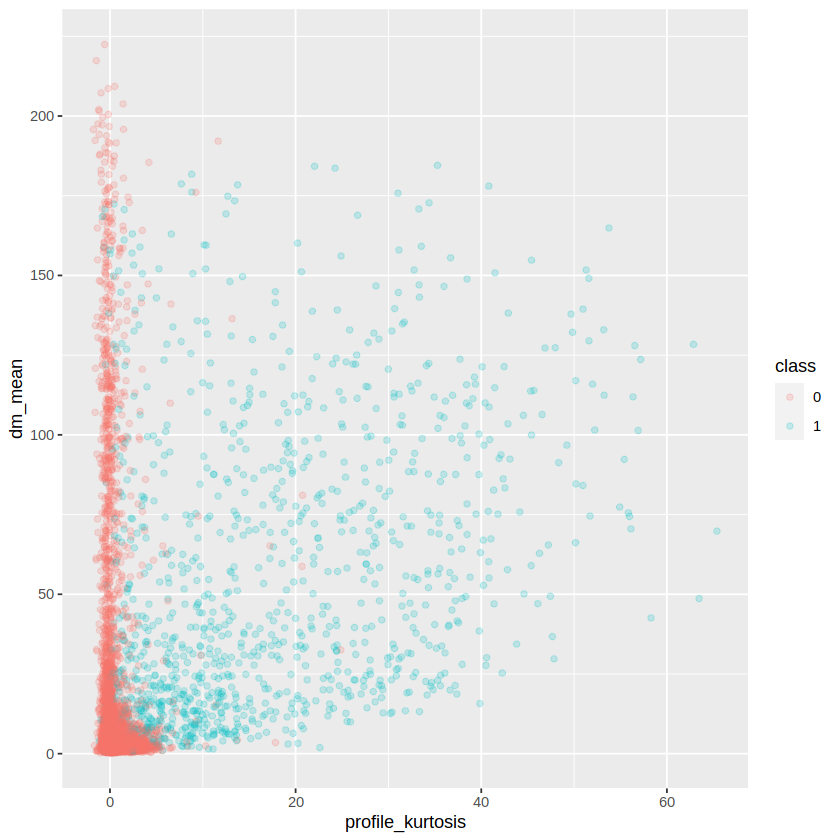

In [7]:
splot_1 <- ggplot(pulsar_train, aes(x = profile_kurtosis, y = dm_mean, color = class)) +
    geom_point(alpha = 0.2)

splot_1

In [28]:
library(themis)

# pulsar_train <- recipe(class ~ ., data = pulsar_train) |>
#     step_upsample(class, over_ratio = 1, skip = FALSE) |>
#     prep() |>
#     bake(pulsar_train)

pulsar_recipe <- recipe(class ~ ., data = pulsar_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

knn_spec <- nearest_neighbor(neighbors = 7, weight_func = "rectangular") |>
    set_engine("kknn") |>
    set_mode("classification")

pulsar_fit <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(knn_spec) |>
    fit(data = pulsar_train)

result <- predict(pulsar_fit, pulsar_test) |>
    bind_cols(pulsar_test)

In [29]:
result |> metrics(truth = class, estimate = .pred_class)
result |> conf_mat(truth = class, estimate = .pred_class)

.metric  .estimator .estimate
1 accuracy binary     0.9456983
2 kap      binary     0.7141395

          Truth
Prediction    0    1
         0 3880   36
         1  207  352

In [27]:
result2 |> metrics(truth = class, estimate = .pred_class)
result2 |> conf_mat(truth = class, estimate = .pred_class)

.metric  .estimator .estimate
1 accuracy binary     0.9456983
2 kap      binary     0.7141395

          Truth
Prediction    0    1
         0 3880   36
         1  207  352